In [140]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
#from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [141]:
mnist = tf.keras.datasets.mnist

In [142]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [143]:
y_train=np.reshape(y_train,(1,60000))
y_test=np.reshape(y_test,(1,10000))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (1, 60000) (10000, 28, 28) (1, 10000)


y = 4


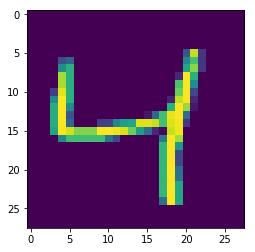

In [144]:
index = 2
plt.imshow(x_train[index])
print ("y = " + str(np.squeeze(y_train[:,index])))


In [145]:
X_train = x_train/255.
X_test = x_test/255.
Y_train =np.zeros((y_train.shape[1],10))
Y_train[np.arange(y_train.shape[1]), y_train] = 1
Y_test =np.zeros((y_test.shape[1],10))
Y_test[np.arange(y_test.shape[1]), y_test] = 1

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 60000
number of test examples = 10000
X_train shape: (60000, 28, 28)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28)
Y_test shape: (10000, 10)


In [146]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32,shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32,shape=(None, n_y))
    ### END CODE HERE ###
    
    return X, Y

In [157]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 1, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("W1", [4,4,1,8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [172]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1],padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    # FLATTEN
    P = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P, 10, activation_fn=None)
    ### END CODE HERE ###

    return Z3

In [173]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    ### END CODE HERE ###
    
    return cost

In [186]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    X_train=np.reshape(X_train,(60000, 28, 28,1))
    X_test=np.reshape(X_test,(10000, 28, 28,1))
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(100):
            
            _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:X_train, Y:Y_train})
            cost1 = temp_cost 
            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, cost1))
            if print_cost == True and epoch % 1 == 0:
                costs.append(cost1)        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 2.471063
Cost after epoch 5: 2.289544
Cost after epoch 10: 2.271956
Cost after epoch 15: 2.242019
Cost after epoch 20: 2.177759
Cost after epoch 25: 2.059083
Cost after epoch 30: 1.858397
Cost after epoch 35: 1.573760
Cost after epoch 40: 1.272319
Cost after epoch 45: 1.028819
Cost after epoch 50: 0.859549
Cost after epoch 55: 0.739685
Cost after epoch 60: 0.648085
Cost after epoch 65: 0.572905
Cost after epoch 70: 0.510329
Cost after epoch 75: 0.457551
Cost after epoch 80: 0.413523
Cost after epoch 85: 0.376422
Cost after epoch 90: 0.345599
Cost after epoch 95: 0.320149


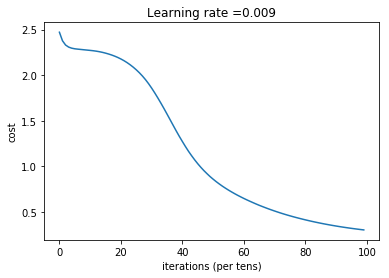

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.90748334
Test Accuracy: 0.9093


In [187]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)